In [ ]:
!pip install pyspark

In [ ]:
# SECTION 1: DATA CLEANING USING PYSPARK

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Starting the Spark Session

spark = SparkSession.builder \
    .appName("Phase2_DataCleaning") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

print("Spark Session Started")


# Loading Dataset

file_path = "/content/drive/MyDrive/ecommerce_2019.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

print("Total rows BEFORE cleaning:", df.count())
df.printSchema()


# Converting to timestamp

df = df.withColumn(
    "event_time",
    to_timestamp("event_time", "yyyy-MM-dd HH:mm:ss z")
)

# Handling missing values

df = df.dropna(subset=["product_id", "user_id"])

df = df.fillna({
    "category_code": "unknown",
    "brand": "unknown"
})


df = df.withColumn("price", col("price").cast(FloatType()))

# Removing outliers
df = df.filter(col("price") >= 0)

# Removing timestamps that is not valid
df = df.filter(col("event_time").isNotNull())

print("Total rows AFTER cleaning:", df.count())
df.show(5)
df.printSchema()


Spark Session Started
Total rows BEFORE cleaning: 67501979
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

Total rows AFTER cleaning: 67501979
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code| brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|2019-11-01 00:00:00|      view|   1003461|2053013555631882655|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019

Starting EDA...
+----------+--------+
|event_type|   count|
+----------+--------+
|      view|63556110|
|      cart| 3028930|
|  purchase|  916939|
+----------+--------+



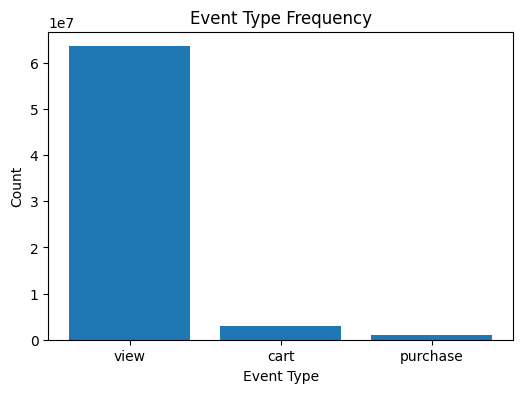

+-------+-------+
|  brand|  count|
+-------+-------+
|unknown|9218235|
|samsung|7889245|
|  apple|6259379|
| xiaomi|4638062|
| huawei|1410126|
|lucente|1185075|
|     lg|1096990|
|  bosch| 975059|
|   oppo| 811698|
|   sony| 798457|
+-------+-------+



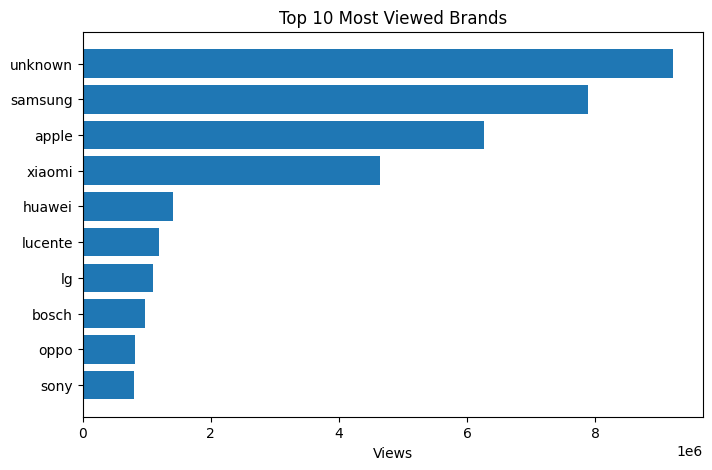

+--------------------+--------+
|       category_code|   count|
+--------------------+--------+
|             unknown|21898171|
|electronics.smart...|16375000|
|electronics.video.tv| 2208046|
|  computers.notebook| 2180554|
|  electronics.clocks| 2086966|
|       apparel.shoes| 1886890|
|electronics.audio...| 1816877|
|appliances.enviro...| 1528058|
|appliances.kitche...| 1427162|
|appliances.kitche...| 1403866|
+--------------------+--------+



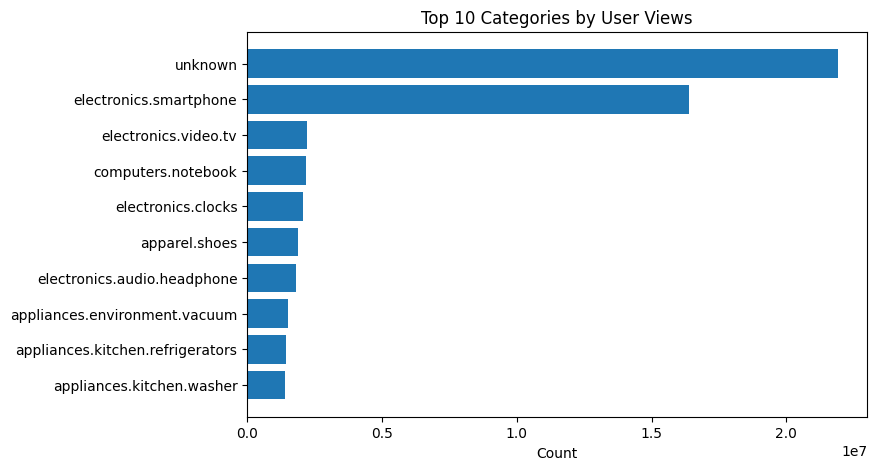

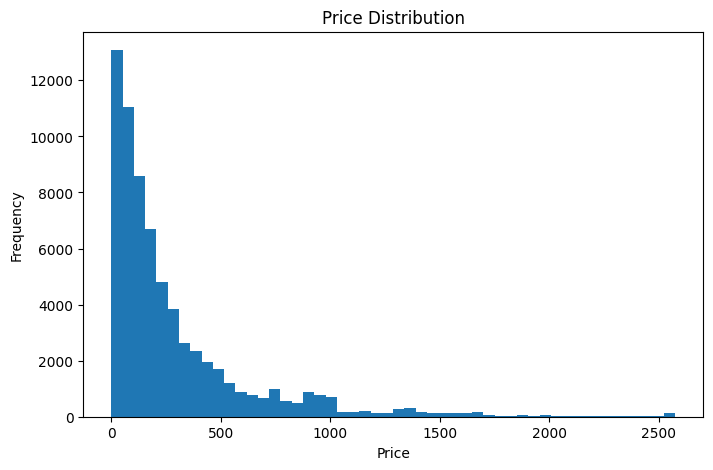

+----------+------+
|      date| count|
+----------+------+
|2019-11-01| 22458|
|2019-11-02| 21864|
|2019-11-03| 22145|
|2019-11-04| 26889|
|2019-11-05| 24875|
|2019-11-06| 25319|
|2019-11-07| 24863|
|2019-11-08| 25714|
|2019-11-09| 22768|
|2019-11-10| 22878|
|2019-11-11| 24931|
|2019-11-12| 22725|
|2019-11-13| 22548|
|2019-11-14| 22124|
|2019-11-16| 68247|
|2019-11-17|185195|
|2019-11-18| 28537|
|2019-11-19| 24967|
|2019-11-20| 24947|
|2019-11-21| 25266|
+----------+------+
only showing top 20 rows



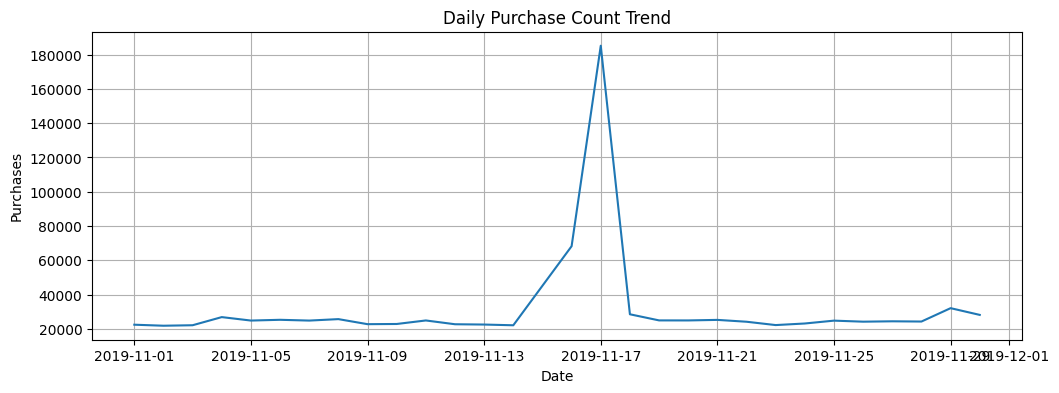

+--------------------+-----+
|        user_session|count|
+--------------------+-----+
|d99d91bf-40f8-4e2...| 4128|
|fc749a4e-c432-4da...| 2466|
|b556f0c7-3a23-44f...| 1963|
|d6433d7b-3846-456...| 1658|
|88206fc3-b5ea-4e3...| 1373|
|af4ad1c0-a131-4fa...| 1294|
|0c307610-aa79-bf1...|  918|
|8c322efd-e368-42a...|  711|
|58c242f5-c85d-446...|  679|
|53c412c9-e864-d0d...|  594|
|85890756-b4a0-4cc...|  550|
|3a1a8cae-b7bd-444...|  534|
|4488e77a-9901-4c4...|  504|
|965efde8-197f-478...|  485|
|727dbaa7-fa0e-4c2...|  472|
|88bfe8fa-2531-4b0...|  464|
|d71a3bca-afc7-447...|  436|
|42e83712-4c9b-c40...|  430|
|0b1c58be-29a4-4bb...|  420|
|9de43f36-3151-470...|  419|
+--------------------+-----+



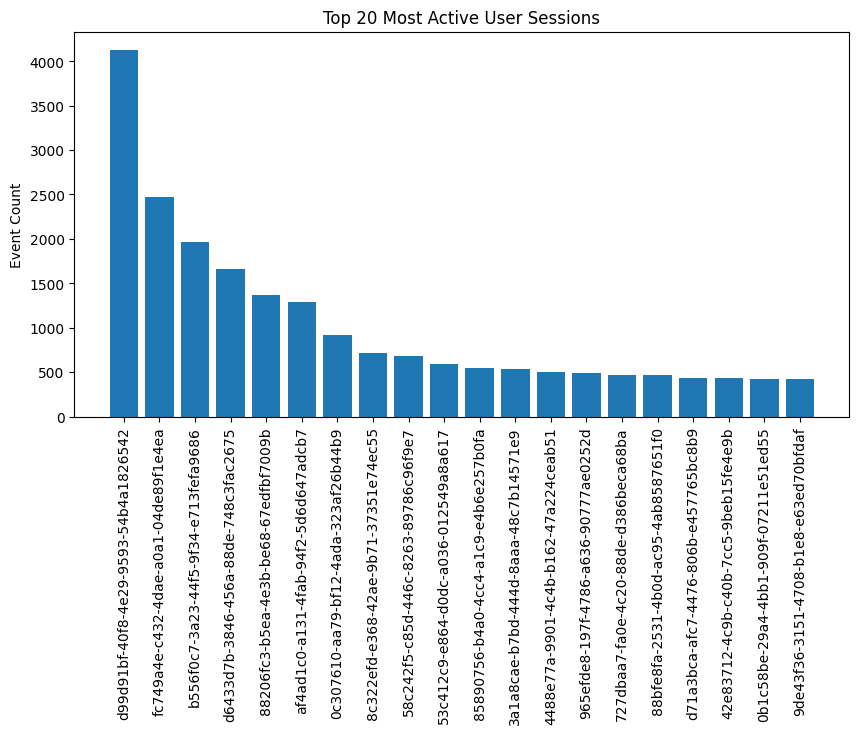

In [ ]:
# SECTION 2: EDA USING PYSPARK

from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt

print("Starting EDA...")

# EDA 1: Event Type Frequency
event_counts = df.groupBy("event_type").count().orderBy(desc("count"))
event_counts.show()

event_pd = event_counts.toPandas()

plt.figure(figsize=(6,4))
plt.bar(event_pd["event_type"], event_pd["count"])
plt.title("Event Type Frequency")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

# EDA 2: Top 10 Brands
top_brands = (df.groupBy("brand")
                .count()
                .orderBy(desc("count"))
                .limit(10))

top_brands.show()

brands_pd = top_brands.toPandas()

plt.figure(figsize=(8,5))
plt.barh(brands_pd["brand"], brands_pd["count"])
plt.title("Top 10 Most Viewed Brands")
plt.xlabel("Views")
plt.gca().invert_yaxis()
plt.show()

# EDA 3: Top 10 Categories
top_categories = (df.groupBy("category_code")
                    .count()
                    .orderBy(desc("count"))
                    .limit(10))

top_categories.show()

cat_pd = top_categories.toPandas()

plt.figure(figsize=(8,5))
plt.barh(cat_pd["category_code"], cat_pd["count"])
plt.title("Top 10 Categories by User Views")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()


# EDA 4: Price Distribution
price_pd = df.select("price").sample(False, 0.001, seed=42).toPandas()

plt.figure(figsize=(8,5))
plt.hist(price_pd["price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# EDA 5: Daily Purchase Trend
daily_sales = (df.filter(col("event_type") == "purchase")
                 .withColumn("date", to_date("event_time"))
                 .groupBy("date")
                 .count()
                 .orderBy("date"))

daily_sales.show()

sales_pd = daily_sales.toPandas()

plt.figure(figsize=(12,4))
plt.plot(sales_pd["date"], sales_pd["count"])
plt.title("Daily Purchase Count Trend")
plt.xlabel("Date")
plt.ylabel("Purchases")
plt.grid(True)
plt.show()

# EDA 6: Session Behavior
session_behavior = (df.groupBy("user_session")
                      .count()
                      .orderBy(desc("count"))
                      .limit(20))

session_behavior.show()

sessions_pd = session_behavior.toPandas()

plt.figure(figsize=(10,5))
plt.bar(sessions_pd["user_session"], sessions_pd["count"])
plt.title("Top 20 Most Active User Sessions")
plt.xticks(rotation=90)
plt.ylabel("Event Count")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reduce dataset for ML implementation (67M → ~670k rows)
df_small = df.sample(False, 0.01, seed=42)
df_small.count()

675965

In [ ]:
from pyspark.sql.functions import *

# Labeling 1 if a purchase exists in session, else 0
session_label = (
    df_small.groupBy("user_session")
    .agg(max(when(col("event_type") == "purchase", 1).otherwise(0)).alias("label"))
)

# Aggregating session behavior
session_features = (
    df_small.groupBy("user_session")
    .agg(
        count("*").alias("total_events"),
        count(when(col("event_type") == "view", True)).alias("total_views"),
        countDistinct("product_id").alias("unique_products"),
        countDistinct("category_code").alias("unique_categories"),
        avg("price").alias("avg_price"),
        countDistinct("brand").alias("unique_brands")
    )
)

session_df = session_features.join(session_label, "user_session", "inner")
session_df = session_df.na.fill(0)
session_df.show(5)

+--------------------+------------+-----------+---------------+-----------------+------------------+-------------+-----+
|        user_session|total_events|total_views|unique_products|unique_categories|         avg_price|unique_brands|label|
+--------------------+------------+-----------+---------------+-----------------+------------------+-------------+-----+
|00003d51-f077-4b4...|           2|          2|              2|                1| 60.10500144958496|            1|    0|
|000047aa-c8c4-408...|           1|          1|              1|                1|47.619998931884766|            1|    0|
|00006325-76f4-4a9...|           1|          1|              1|                1| 163.4499969482422|            1|    0|
|00006a96-5e74-427...|           1|          1|              1|                1|179.16000366210938|            1|    0|
|00009905-2937-472...|           2|          2|              2|                1|110.04499816894531|            2|    0|
+--------------------+----------

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "total_events",
    "total_views",
    "unique_products",
    "unique_categories",
    "avg_price",
    "unique_brands"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

final_df = assembler.transform(session_df).select("features", "label")

In [ ]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_model = lr.fit(train_df)
lr_preds = lr_model.transform(test_df)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rf_model = rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train_df)
gbt_preds = gbt_model.transform(test_df)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
eval_f1  = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

print("LR Accuracy:", eval_acc.evaluate(lr_preds))
print("RF Accuracy:", eval_acc.evaluate(rf_preds))
print("GBT Accuracy:", eval_acc.evaluate(gbt_preds))

print("LR F1:", eval_f1.evaluate(lr_preds))
print("RF F1:", eval_f1.evaluate(rf_preds))
print("GBT F1:", eval_f1.evaluate(gbt_preds))

LR Accuracy: 0.9852875825292027
RF Accuracy: 0.9855573895378364
GBT Accuracy: 0.985493905535805
LR F1: 0.978834505083298
RF F1: 0.9783886108663145
GBT F1: 0.9784507151079349


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.0, 0.1, 0.2])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build()
)

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=eval_f1,
    numFolds=3
)

cv_model = cv.fit(train_df)
cv_preds = cv_model.transform(test_df)

print("Best Tuned LR F1:", eval_f1.evaluate(cv_preds))

Best Tuned LR F1: 0.978834505083298


In [ ]:
category_df = (
    df_small.groupBy("category_code")
    .agg(
        count("*").alias("total_events"),
        count(when(col("event_type")=="view",True)).alias("views"),
        count(when(col("event_type")=="purchase",True)).alias("purchases"),
        avg("price").alias("avg_price"),
        countDistinct("user_id").alias("unique_users")
    )
).na.fill(0)

In [ ]:
cluster_cols = ["total_events","views","purchases","avg_price","unique_users"]

assembler = VectorAssembler(inputCols=cluster_cols, outputCol="features")
category_final = assembler.transform(category_df)

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5, seed=42)
k_model = kmeans.fit(category_final)

cluster_df = k_model.transform(category_final)
cluster_df.show(10)

+--------------------+------------+-----+---------+------------------+------------+--------------------+----------+
|       category_code|total_events|views|purchases|         avg_price|unique_users|            features|prediction|
+--------------------+------------+-----+---------+------------------+------------+--------------------+----------+
|    computers.ebooks|         468|  448|        4|148.96745680132483|         428|[468.0,448.0,4.0,...|         0|
|apparel.shoes.sli...|          52|   52|        0|  42.0451922416687|          51|[52.0,52.0,0.0,42...|         0|
|computers.periphe...|         877|  847|        3| 55.42627155576899|         773|[877.0,847.0,3.0,...|         0|
|appliances.kitche...|         178|  172|        2| 35.86741556210464|         165|[178.0,172.0,2.0,...|         0|
|electronics.video...|         214|  210|        0| 791.0001378995236|         198|[214.0,210.0,0.0,...|         0|
|     sport.snowboard|         190|  180|        2|258.53178887618213|  

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(cluster_df)

print("Silhouette Score:", silhouette)

Silhouette Score: 0.845414473605742


In [ ]:
daily_df = (
    df_small.filter(col("event_type")=="purchase")
    .withColumn("date", to_date("event_time"))
    .groupBy("date")
    .count()
    .withColumnRenamed("count","sales")
    .orderBy("date")
)

In [ ]:
daily_df = (
    daily_df
    .withColumn("day_of_week", dayofweek("date"))
    .withColumn("day_of_month", dayofmonth("date"))
)

In [ ]:
reg_features = ["day_of_week", "day_of_month"]

assembler = VectorAssembler(inputCols=reg_features, outputCol="features")
reg_df = assembler.transform(daily_df).select("features", "sales")

In [ ]:
train_reg, test_reg = reg_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression

lr_reg = LinearRegression(featuresCol="features", labelCol="sales")
lr_reg_model = lr_reg.fit(train_reg)
lr_reg_preds = lr_reg_model.transform(test_reg)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf_reg = RandomForestRegressor(featuresCol="features", labelCol="sales")
rf_reg_model = rf_reg.fit(train_reg)
rf_reg_preds = rf_reg_model.transform(test_reg)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

eval_rmse = RegressionEvaluator(labelCol="sales", metricName="rmse")
eval_mae  = RegressionEvaluator(labelCol="sales", metricName="mae")

print("LR RMSE:", eval_rmse.evaluate(lr_reg_preds))
print("LR MAE :", eval_mae.evaluate(lr_reg_preds))

print("RF RMSE:", eval_rmse.evaluate(rf_reg_preds))
print("RF MAE :", eval_mae.evaluate(rf_reg_preds))

LR RMSE: 695.4110068825713
LR MAE : 311.4885160703165
RF RMSE: 671.5199049870004
RF MAE : 296.94666666666666


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(pred_df, model_name):
    """
    pred_df: Spark DataFrame with columns ["label", "probability"]
    model_name: string label for title
    """

    # Extract probability column (Spark Vector -> Python float)
    pdf = pred_df.select("label", "probability").toPandas()
    pdf["prob"] = pdf["probability"].apply(lambda x: float(x[1]) if len(x) > 1 else float(x))

    y_true = pdf["label"].values
    y_score = pdf["prob"].values

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

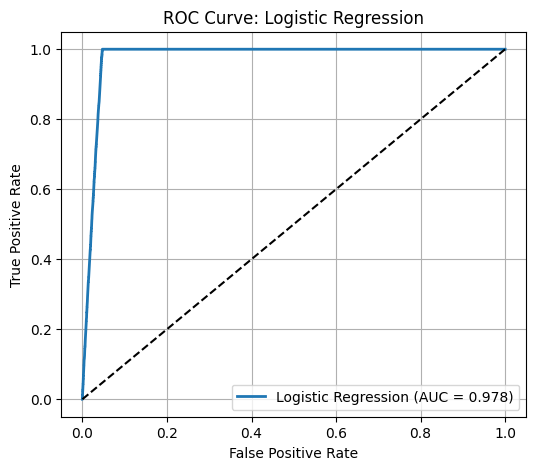

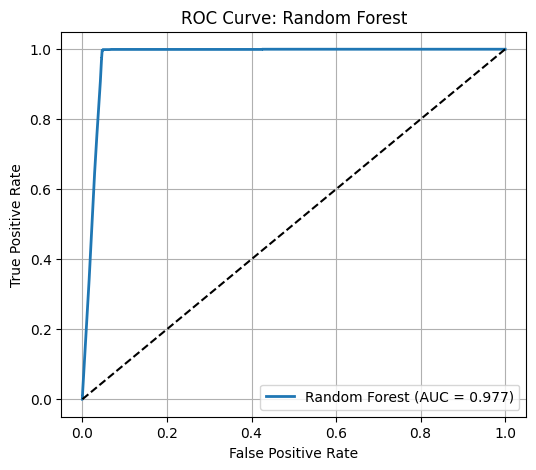

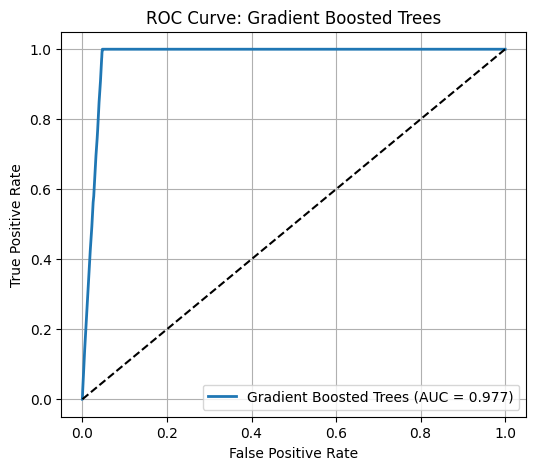

In [ ]:
plot_roc_curve(lr_preds, "Logistic Regression")
plot_roc_curve(rf_preds, "Random Forest")
plot_roc_curve(gbt_preds, "Gradient Boosted Trees")